In [5]:
import os
os.environ["OMP_NUM_THREADS"] = '1' # imposes number of cores
import numpy as np
import matplotlib.pyplot as plt
# import h5py
from scipy.sparse import csr_matrix, csc_matrix, lil_matrix
from scipy.sparse.linalg import eigs as sparse_eigs
# import skopt
# from skopt.space import Real
# from skopt.learning import GaussianProcessRegressor as GPR
# from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel, Product, ConstantKernel
import matplotlib as mpl
from scipy.io import loadmat
import time
from scipy.io import savemat
# from skopt.plots import plot_convergence
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('dark_background')
#Latex
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')


# In val_functions there are the validation strategies
# %run ./Val_Functions.ipynb
# In functions there are the ESN functions
%run ./Functions.ipynb

mainfold ='./'
loadprev  = 0 # 1:Load previously trained ESN data; 0: train again
check_clv = 0 # Check CLVs flag
norm_time = 1 # Normalization time for QR decomposition in LEs
 
#all if full CLVs are to be saved. angles if only their angles from dot product are saved
saveclvs = 'angles'
#saveclvs = 'all'

### Dataset generation

We start by generating the timeseries of the Lorenz system using forward Euler nad splitting the data in washout, training, validation and test.

In [6]:
# Choose Dynamical system
# system = 'lorenz96'
# system = 'lorenz63'
# system = 'rossler'
system = 'cdv'

upsample = 1               # to increase the dt of the ESN wrt the numerical integrator

if system == 'lorenz96':
    params = 8.
    dim = 10
    N_units = 1000  # neurons #or 4000 for dim=20
    # starting point on the attractor
    # u0 = 20*(np.random.rand(dim) - 0.5) #random
    dt = 0.01*upsample  # time step
    if dim == 10:
        t_lyap = 1.2**(-1)       # Lyapunov Time dim = 10
        subspace_LEs_indeces = [3, 1]
        u0 = np.array([5.22196394, -1.51558431, -4.34570876, -0.77345849,  6.95503428,
                       7.29261052, -3.15761016,  1.67864043,  2.84273581,  4.49401018])
    elif dim == 20:
        t_lyap = 1.5**(-1)     # Lyapunov Time dim=20
        subspace_LEs_indeces = [6, 1]
        u0 = np.array([-0.41551129, -1.83742654, -1.41025459,  6.40579129,  6.46965049,
                       3.26477452,  5.87700405, -0.60882665, -3.46431662,  0.61291811,
                       7.92510557,  3.83353264, -3.14415806, -0.49186308, -1.31767124,
                       -2.33572901,  2.96791844, 12.85790068, -0.0429301,  2.47473015])

if system == 'lorenz63':
    params = [8/3, 28, 10]
    dim = 3
    N_units = 100  # neurons
    # starting point on the attractor
    u0 = np.array([7.432487609628195, 10.02071718705213, 29.62297428638419])
    dt = 0.005*upsample  # time step
    t_lyap = 0.9**(-1)       # Lyapunov Time
    subspace_LEs_indeces = []
if system == 'rossler':
    params = [0.1, 0.1, 14]
    dim = 3
    N_units = 100  # neurons
    # starting point on the attractor
    u0 = np.array([7.55576471,  15.53252411,  0.57289182])
    dt = 0.01*upsample  # time step
    t_lyap = 0.07**(-1)       # Lyapunov Time
    subspace_LEs_indeces = []
if system == 'cdv':
    params = [0.95, -0.76095, 0.1, 1.25, 0.2, 0.5]
    dim = 6
    N_units = 400  # neurons
    dt = 0.1*upsample  # time step
    t_lyap = 0.02**(-1)       # Lyapunov Time
    u0 = np.array([0.74386288,  0.19322051, -0.34494619, -
                  0.3342756, -0.11471851, 0.34287484])
    subspace_LEs_indeces = [1, 1]


N_lyap = int(t_lyap/dt)  # number of time steps in one Lyapunov time
print('N_lyap:', N_lyap)

# number of time steps for washout, train, validation, test
N_washout = 2*N_lyap
N_train = 400*N_lyap  # 1000*N_lyap
N_val = 3*N_lyap
N_test = 400*N_lyap  # 4000*N_lyap

N_lyap: 500


In [7]:
# Function to create directories
def mkdir(foldnm):
    if os.path.exists(foldnm):
        print("Directory '{}' already exists.".format(foldnm))
    else:
        try:
            os.makedirs(foldnm)
            print("Successfully created the directory '{}'.".format(foldnm))
        except OSError:
            print("Creation of the directory '{}' failed.".format(foldnm))

Directory './cdv/target_data_N_6/CLV_results/' already exists.
Dynamical system: cdv
Target Lyapunov exponents:  [ 0.02498475  0.00085164 -0.08082325 -0.10112341 -0.21763144 -0.22625822]
norm =  [0.22260427 0.43515797 0.49893387 0.53282914 0.88808202 0.78014158]


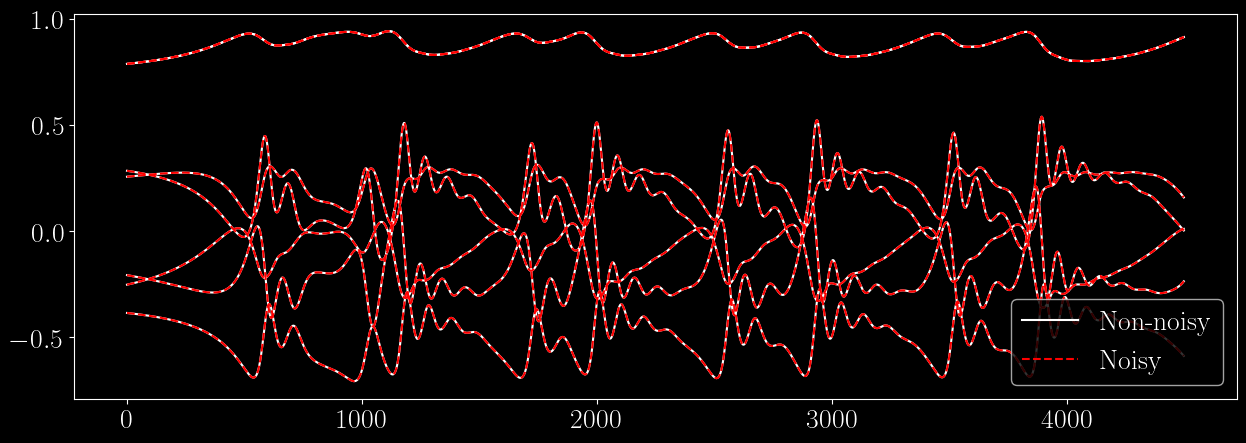

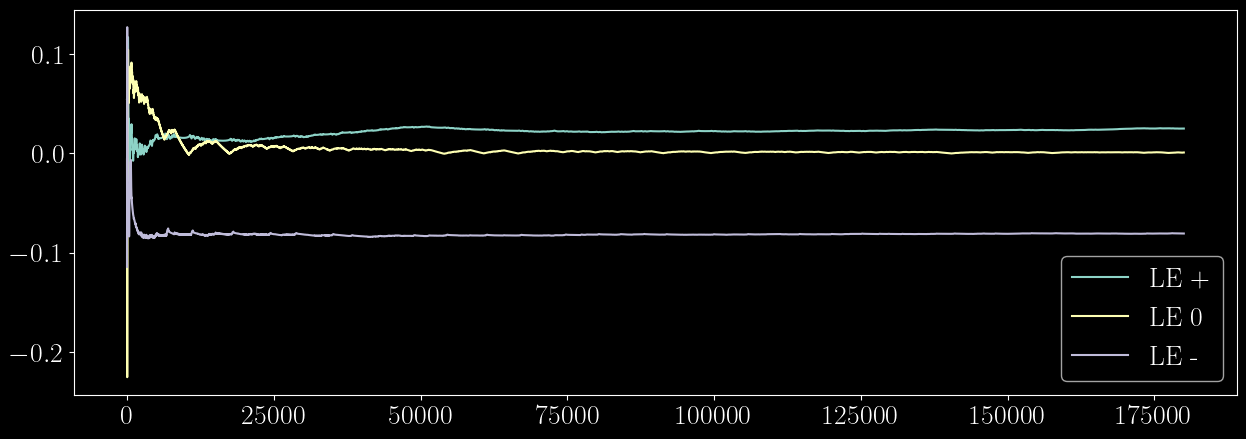

CPU times: user 33.8 s, sys: 87.9 ms, total: 33.8 s
Wall time: 41.2 s


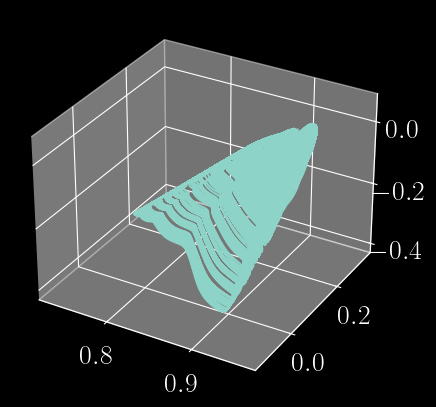

In [8]:
%%time

targetresults = mainfold+system+'/target_data_N_'+str(dim)+'/CLV_results/'
mkdir(targetresults)

#The total timesteps
Ntotal = (N_washout+N_train+N_val+N_test)*upsample
#Timesteps to be discraded as a transient for the initial LEs and CLVs calculation
Ntherm = (N_washout+N_train+N_val)*upsample + int(N_test*upsample/10)

ensemble=1
for realization in range(ensemble):
    fname = targetresults+'ESN_target_CLV_dt_'+ str(dt)+'_noise_0_ens_'+str(realization)        
    du0 = 0.01*(np.random.rand(dim) - 0.5)    
    v0 = u0.copy() + du0
    U, LEs    = solve_ode_LEs(system,Ntotal,Ntherm,dt/upsample,\
                    v0, saveclvs, params, fname, subspace_LEs_indeces, norm_time)#[::upsample]
    LEs_targ = LEs[-1]
    print('Target Lyapunov exponents: ',LEs_targ)

# compute norm
U_data = U[:N_washout+N_train].copy()
m = U_data.min(axis=0)
M = U_data.max(axis=0)
norm = M-m #be sure to use the same norm when running on another file. It is saved at the end
print('norm = ',norm)

# washout
U_washout = U[:N_washout].copy()
# data to be used for training + validation
U_tv  = U[N_washout:N_washout+N_train-1].copy()
Y_tv  = U[N_washout+1:N_washout+N_train].copy()
# plotting part of training data to visualize noise
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 20
plt.plot(U_tv[:3*N_val,0], c='w', label='Non-noisy')
plt.plot(U_tv[:3*N_val], c='w')

# adding noise to training set inputs with sigma_n the noise of the data
seed = 0   #to be able to recreate the data
rnd1  = np.random.RandomState(seed)
noisy = True
if noisy:
    data_std = np.std(U,axis=0)
    sigma_n = 0.0005         #change this to increase/decrease noise in training inputs
    for i in range(dim):
        U_tv[:,i] = U_tv[:,i] \
                        + rnd1.normal(0, sigma_n*data_std[i], N_train-1)
    plt.plot(U_tv[:3*N_val,0], 'r--', label='Noisy')
    plt.plot(U_tv[:3*N_val], 'r--')
else:
    sigma_n=0
plt.legend()
plt.show()

plt.plot(LEs[:,0], label='LE +');
plt.plot(LEs[:,1], label='LE 0');
if dim > 2:
    plt.plot(LEs[:,2], label='LE -');
plt.legend()
plt.show()
if system=='lorenz96':
    fig = plt.figure()
    ax = fig.add_subplot(111);
    timeN = np.shape(U[:N_train])[0]
    fulltime = np.arange(timeN) / N_lyap
    fullspace = np.arange(dim)    
    imag = ax.contourf(fullspace,fulltime,U[:N_train]);
    plt.colorbar(imag)
    
    fig = plt.figure();
    plt.plot(fullspace,LEs[-1],'-o');
    plt.grid(True,c='lightgray',linestyle='--', linewidth=0.5);
    plt.xlabel('Lyapunov exponents',fontsize=14);
    
    
else:
    if dim>2:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d');
        ax.plot(U[:,0],U[:,1],U[:,2]);
    else:
        fig = plt.figure()        
        plt.plot(U[:,0],U[:,1]);

### ESN Initiliazation Hyperparameters

To generate the Echo State Networks realizations we set the hyperparameters 

In [ ]:
# network parameters
bias_in = np.array([1.])  # input bias
bias_out = np.array([1.])  # output bias

connectivity = 3
sparseness = 1 - connectivity/(N_units-1)

# prediction horizon normalization factor and threshold
sigma_ph = np.sqrt(np.mean(np.linalg.norm(U, axis=1)**2))
threshold_ph = 0.4

# Tikhonov factor (optimized among the values in this list)
tikh = np.array([1e-6, 1e-8, 1e-10, 1e-12])

###  Grid Search and Bayesian Optimization

Here we set the parameters for Grid Search and Bayesian Optimization.

In [ ]:
n_in = 0  # Number of Initial random points

spec_in = .1  # range for hyperparameters (spectral radius and input scaling)
spec_end = 1.
in_scal_in = np.log10(0.1)
in_scal_end = np.log10(5.)

# In case we want to start from a grid_search, the first n_grid_x*n_grid_y points are from grid search
n_grid_x = 6
n_grid_y = 6
n_bo = 5  # number of points to be acquired through BO after grid search
n_tot = n_grid_x*n_grid_y + n_bo  # Total Number of Function Evaluatuions


# computing the points in the grid
if n_grid_x > 0:
    x1 = [[None] * 2 for i in range(n_grid_x*n_grid_y)]
    k = 0
    for i in range(n_grid_x):
        for j in range(n_grid_y):
            x1[k] = [spec_in + (spec_end - spec_in)/(n_grid_x-1)*i,
                     in_scal_in + (in_scal_end - in_scal_in)/(n_grid_y-1)*j]
            k += 1

# range for hyperparameters
search_space = [Real(spec_in, spec_end, name='spectral_radius'),
                Real(in_scal_in, in_scal_end, name='input_scaling')]

# ARD 5/2 Matern Kernel with sigma_f in front for the Gaussian Process
kernell = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-1, 3e0)) *\
    Matern(length_scale=[0.2, 0.2], nu=2.5, length_scale_bounds=(5e-2, 1e1))


# Hyperparameter Optimization using either Grid Search or Bayesian Optimization
def g(val):

    # Gaussian Process reconstruction
    b_e = GPR(kernel=kernell,
              # if true mean assumed to be equal to the average of the obj function data, otherwise =0
              normalize_y=True,
              # number of random starts to find the gaussian process hyperparameters
              n_restarts_optimizer=3,
              noise=1e-10,  # only for numerical stability
              random_state=10)  # seed

    # Bayesian Optimization
    res = skopt.gp_minimize(val,                         # the function to minimize
                            search_space,                      # the bounds on each dimension of x
                            base_estimator=b_e,        # GP kernel
                            acq_func="EI",       # the acquisition function
                            n_calls=n_tot,      # total number of evaluations of f
                            x0=x1,         # Initial grid search points to be evaluated at
                            n_random_starts=n_in,       # the number of additional random initialization points
                            n_restarts_optimizer=3,          # number of tries for each acquisition
                            random_state=10,         # seed
                            )
    return res

### Validate Echo State
Select validation function to select the hyperparameters for each realization in the ensemble of networks

In [7]:
%%time
#Number of Networks in the ensemble
ensemble = 2
# Which validation strategy (implemented in Val_Functions.ipynb)
# There are Recycle, K-Fold and Recycle with Prediction Horizon (instead of MSE)
# Using Prediction Horizon requires adjustments, but Recycle and K-fold with MSE should be fine
val      = RVC_Noise  #KFC_Noise #SSV
N_fo     = 1                        # number of validation intervals
N_in     = N_washout                # timesteps before the first validation interval (can't be 0 due to implementation)
N_fw     = (N_train-1-N_in)//(N_fo) # how many steps forward the validation interval is shifted (in this way they are evenly spaced)
N_splits = 4 

# Train the network if loadprev == 0
if loadprev == 0:
    #Quantities to be saved
    par      = np.zeros((ensemble, 4))      # GP parameters
    x_iters  = np.zeros((ensemble,n_tot,2)) # coordinates in hp space where f has been evaluated
    f_iters  = np.zeros((ensemble,n_tot))   # values of f at those coordinates
    minimum  = np.zeros((ensemble, 4))      # minima found per each member of the ensemble

    # to store optimal hyperparameters and matrices
    tikh_opt = np.zeros(n_tot)
    Woutt    = np.zeros(((ensemble, N_units+1,dim)))
    Winn     = [] #save as list to keep single elements sparse #np.zeros((ensemble, N_units, dim+1))
    Ws       = [] #np.zeros((ensemble,N_units, N_units))

    # save the final gp reconstruction for each network
    gps      = [None]*ensemble


    for i in range(ensemble):

        print('Realization    :',i+1)

        k   = 0

        # Win and W generation
        seed= i+1
        rnd = np.random.RandomState(seed)

        #sparse syntax for the input and state matrices
        Win  = lil_matrix((N_units,dim+1)) 
        for j in range(N_units):
            Win[j,rnd.randint(0, dim+1)] = rnd.uniform(-1, 1)
        Win = Win.tocsr()

        W = csr_matrix(
            rnd.uniform(-1, 1, (N_units, N_units)) * (rnd.rand(N_units, N_units) < (1-sparseness)))

        spectral_radius = np.abs(sparse_eigs(W, k=1, which='LM', return_eigenvectors=False))[0]
        W = (1/spectral_radius)*W #scaled to have unitary spec radius  

        # Bayesian Optimization
        tt       = time.time()
        res      = g(val)
        print('Total time:', time.time() - tt)


        #Saving Quantities for post_processing
        gps[i]     = res.models[-1]    
        gp         = gps[i]
        x_iters[i] = np.array(res.x_iters)
        f_iters[i] = np.array(res.func_vals)
        minimum[i] = np.append(res.x,[tikh_opt[np.argmin(f_iters[i])],res.fun])
        params     = gp.kernel_.get_params()
        key        = sorted(params)
        par[i]     = np.array([params[key[2]],params[key[5]][0], params[key[5]][1], gp.noise_])

        #saving matrices
        Woutt[i]   = train_save_n(U_washout, U_tv, U[N_washout+1:N_washout+N_train],
                                  minimum[i,2],10**minimum[i,1], minimum[i,0], minimum[i,3])
        Winn    += [Win] #append to list #Win.toarray()
        Ws      += [W]   #W.toarray()


        #Plotting Optimization Convergence for each network
        print('Best Results: x', minimum[i,0], 10**minimum[i,1], minimum[i,2],
              'f', -minimum[i,-1])
        plt.rcParams["figure.figsize"] = (15,2)
        plt.figure()
        plot_convergence(res)
        plt.show()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


## Test set

Running the networks in the test set and calculate the LEs and CLVs from trained ESNs

Realization    : 1
Win : (100, 4)
W : (100, 100)
Wout : (101, 3)
norm : (3,)
opt_hyp : (3,)
Directory './lorenz63/data_N_100_dim_3/CLV_results/' already exists.
Inside closed loop i= 20000
Inside closed loop i= 40000
Inside closed loop i= 60000
Inside closed loop i= 80000
ESN Lyapunov exponents:  [ 9.21602028e-01 -1.41418099e-03 -1.46363332e+01]
Calculate CLVs

Realization    : 2
Win : (100, 4)
W : (100, 100)
Wout : (101, 3)
norm : (3,)
opt_hyp : (3,)
Directory './lorenz63/data_N_100_dim_3/CLV_results/' already exists.
Inside closed loop i= 20000
Inside closed loop i= 40000
Inside closed loop i= 60000
Inside closed loop i= 80000
ESN Lyapunov exponents:  [ 9.04879648e-01 -2.14602208e-03 -1.46283710e+01]
Calculate CLVs

Averaged Lyapunov Exponents:  [ 9.13240838e-01 -1.78010153e-03 -1.46323521e+01]
Target Lyapunov exponents:    [ 9.12736828e-01  1.28020363e-03 -1.45806774e+01]
CPU times: user 29.2 s, sys: 279 ms, total: 29.5 s
Wall time: 29.6 s


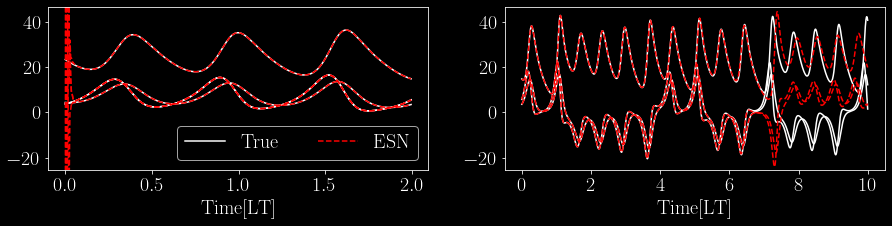

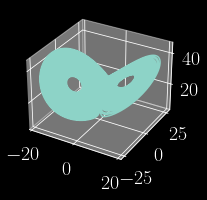

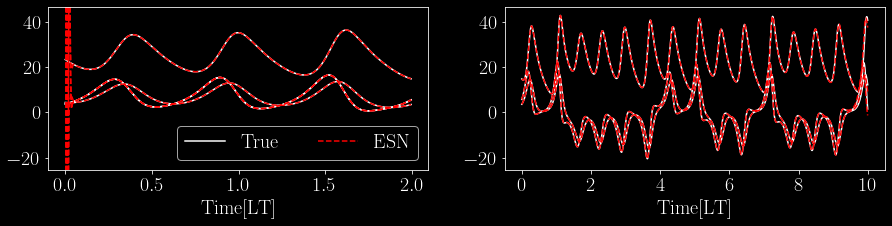

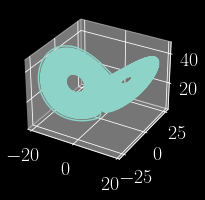

In [9]:
%%time
N_test   = 1#50                       # number of intervals in the test set
N_tstart = N_washout + N_train + 10   # where the first interval starts
N_intt   = 400*N_lyap #4000*N_lyap    # length of the test set interval


#Initialize Lyapunov exponents averaged among different Ensembles.
avg_LE = np.zeros(dim)

ensemble = 2 # number of independent ESN realizations.

for j in range(ensemble):
    
    print('Realization    :',j+1)
    
    #set matrices and hyperparameters
    if loadprev == 1:
        sigma_n = 0.0005        
        fln = './'+system+'/data_N_'+str(N_units)+'_dim_'+str(dim)+\
        '/ESN_' + val.__name__ +'_dt_'+ str(dt)+'_noise_'+str(sigma_n)+'.mat'

        data    = loadmat(fln)
        Win     = data['Win'][0][j]
        W       = data['W'][0][j]
        Wout    = data['Wout'][j]
        norm    = data['norm'][0]
        opt_hyp = data['opt_hyp'][j]

        print('Win :',np.shape(Win))
        print('W :',np.shape(W))
        print('Wout :',np.shape(Wout))
        print('norm :',np.shape(norm))        
        print('opt_hyp :',np.shape(opt_hyp))
        
        rho      = opt_hyp[0].copy()
        sigma_in = opt_hyp[1].copy()
        tikhonov = opt_hyp[2].copy()
    else:
        rho      = minimum[j,0].copy()
        sigma_in = 10**minimum[j,1].copy()
        tikhonov = minimum[j,2].copy()
        Wout     = Woutt[j].copy()
        Win      = Winn[j] #csr_matrix(Winn[j])
        W        = Ws[j]   #csr_matrix(Ws[j])
    
    # to store prediction horizon in the test set
    PH       = np.zeros(N_test)
    
    plot = True #False
    if plot:
        n_plot = 1
        plt.rcParams["figure.figsize"] = (15,3*n_plot)
        plt.figure()
        plt.tight_layout()
    
    #run different test intervals
    for i in range(N_test):
        
        # data for washout and target in each interval
        U_wash    = U[N_tstart - N_washout +i*N_intt : N_tstart + i*N_intt].copy()
        Y_t       = U[N_tstart + i*N_intt            : N_tstart + i*N_intt + N_intt].copy() 
              
        #washout for each interval
        Xa1     = open_loop(U_wash, np.zeros(N_units), sigma_in, rho)
        Uh_wash = np.dot(Xa1, Wout)        
        
        datafold = mainfold+system+'/data_N_'+str(N_units)+'_dim_'+str(dim)+'/CLV_results/'
        mkdir(datafold)
        #Filename of saved ESN timeseries and data
        fname    = datafold+'CLV_' + val.__name__ +'_dt_'+ str(dt)+\
                        '_noise_'+str(sigma_n)+'_ens_'+str(j)+'_ntest_'+str(i)
        
        if upsample > 1:
            fname += '_upsample_'+str(upsample)
        
        ### RUN the closed loop
        Yh_t, xa, exponents_vec = closed_loop_jacobian(N_intt-1, Xa1[-1], Wout,\
                                sigma_in, rho, norm_time, fname,\
                                saveclvs, system, subspace_LEs_indeces, params)
        
        Y_err       = np.linalg.norm((Yh_t[0]-Y_t),axis=1)/sigma_ph
        PH[i]       = np.argmax(Y_err>threshold_ph)/N_lyap
        if PH[i] == 0 and Y_err[0]<threshold_ph: PH[i] = N_intt/N_lyap #(in case PH is larger than interval)
        
        avg_LE += np.array(exponents_vec)[-1,:] / (N_test*ensemble)
        
        if plot:
            #left column has the washout (open-loop) and right column the prediction (closed-loop)
            # only first n_plot test set intervals are plotted
            if i<n_plot:
                plt.subplot(n_plot,2,1+i*2)
                xx = np.arange(U_wash[:,-2].shape[0])/N_lyap                
                plt.plot(xx,U_wash[:,-2], 'w', label='True')
                plt.plot(xx, U_wash[:,:], 'w')
                plt.plot(xx,Uh_wash[:-1,-2], '--r', label='ESN')                
                plt.plot(xx, Uh_wash[:-1,:],'--r')                
                plt.ylim(Y_t[:,:].min()-.1, Y_t[:,:].max()+.1)
                plt.xlabel('Time[LT]')                
                plt.legend(ncol=2)
                plt.subplot(n_plot,2,2+i*2)
                #tsize=Yh_t[:,-2].shape[0]
                tsize=10*N_lyap
                xx = np.arange(tsize)/N_lyap                
                plt.plot(xx,Y_t[:tsize,:], 'w')
                plt.plot(xx,Yh_t[:tsize,:], '--r')
                plt.ylim(Y_t[:,:].min()-.1, Y_t[:,:].max()+.1)
                plt.xlabel('Time[LT]')
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot(Yh_t[:,0],Yh_t[:,1],Yh_t[:,2]);
    
    print('')
print('Averaged Lyapunov Exponents: ', avg_LE)
print('Target Lyapunov exponents:   ',LEs_targ)


## Visualize hyperparameter search

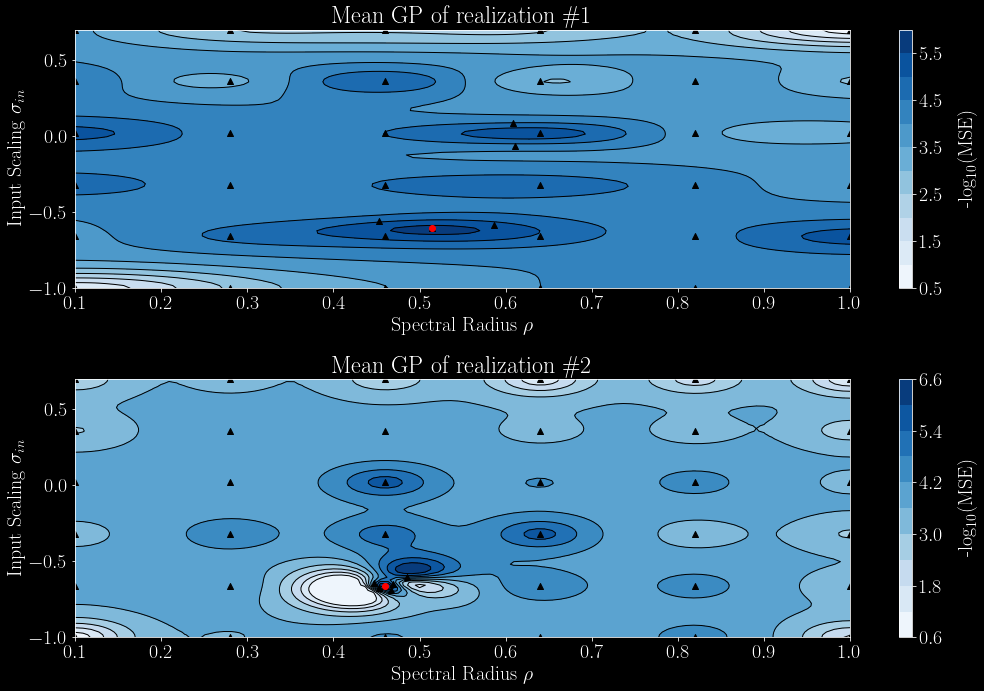

In [ ]:
# Plot Gaussian Process reconstruction for each network in the ensemble afte n_tot evaluations
# The GP reconstruction is based on the n_tot function evaluations decided in the search

# points to evaluate the GP at
n_length = 100
xx, yy = np.meshgrid(np.linspace(spec_in, spec_end, n_length),
                     np.linspace(in_scal_in, in_scal_end, n_length))
x_x = np.column_stack((xx.flatten(), yy.flatten()))
# gp prediction needs this normalized format
x_gp = res.space.transform(x_x.tolist())
y_pred = np.zeros((ensemble, n_length, n_length))

plt.rcParams["figure.figsize"] = (15, 5*ensemble)
plt.rcParams["font.size"] = 20


fig = plt.figure()

for i in range(ensemble):
    # retrieve the gp reconstruction
    gp = gps[i]

    pred, pred_std = gp.predict(x_gp, return_std=True)

    plt.subplot(ensemble, 1, 1+i)

    amin = np.amin([10, f_iters.max()])

    y_pred[i] = np.clip(-pred, a_min=-amin,
                        a_max=-f_iters.min()).reshape(n_length, n_length)
    # Final GP reconstruction for each realization at the evaluation points

    plt.title('Mean GP of realization \#' + str(i+1))

    # Plot GP Mean
    plt.xlabel(r'Spectral Radius $\rho$')
    plt.ylabel(r'Input Scaling $\sigma_{in}$')
    CS = plt.contourf(xx, yy, y_pred[i], levels=10, cmap='Blues')
    cbar = plt.colorbar()
    cbar.set_label('-$\log_{10}$(MSE)', labelpad=15)
    CSa = plt.contour(xx, yy, y_pred[i], levels=10, colors='black',
                      linewidths=1, linestyles='solid')
    #   Plot the n_tot search points
    plt.scatter(x_iters[i, :, 0], x_iters[i, :, 1], c='k', marker='^')
    rho = minimum[i, 0].copy()
    sigma_in = minimum[i, 1].copy()
    plt.plot(rho, sigma_in, 'ro')

fig.tight_layout()
plt.show()

## Save Results

In [ ]:
# Save the details and results of the search for post-process
opt_specs = [spec_in, spec_end, in_scal_in, in_scal_end]
savedir = './'+system+'/data_N_'+str(N_units)+'_dim_'+str(dim)+'/'
mkdir(savedir)
fln = savedir+'ESN_' + val.__name__ + '_dt_' + str(dt)+'_noise_'+str(sigma_n)
if upsample > 1:
    fln += '_upsample_'+str(upsample)
with open(fln+'.mat', 'wb') as f:  # need 'wb' in Python3
    savemat(f, {"norm": norm})
    # savemat(f, {"fix_hyp": np.array([bias_in, N_washout],dtype='float64')})
    savemat(f, {'opt_hyp': np.column_stack(
        (minimum[:, 0], 10**minimum[:, 1], minimum[:, 2]))})
    savemat(f, {"Win": Winn})
    savemat(f, {'W': Ws})
    savemat(f, {"Wout": Woutt})
print(fln)

# to load in another file
# data = loadmat(fln)
# Win  = data['Win'][0] #gives Winn

Directory './lorenz63/data_N_100_dim_3/' already exists.
./lorenz63/data_N_100_dim_3/ESN_RVC_Noise_dt_0.005_noise_0.0005
